# Lab 6

## Jennifer Vo, lab partners with William Olsen
In this lab, we will be exploring plotting background signals and injected signals of an experiment on a 2D histogram to demonstrate Bayes' Theorem.

Recall that Bayes' Theorem is given by $P(signal|data) = P(data|signal)P(signal)P(data)$.

In this lab we are focused on trying to find $P(signal|data)$, the probability of what the true signal of an experiment could have been given a data observation that was made.

## Setup

To set up this lab I will start by making fake background data. 

For our background, we will use a Poisson distribution with a mean of 100. I am going to create this data and then plot it to visualize the background.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import math
import pickle

#this sets the size of the plots to something useful
plt.rcParams["figure.figsize"] = (10,8)

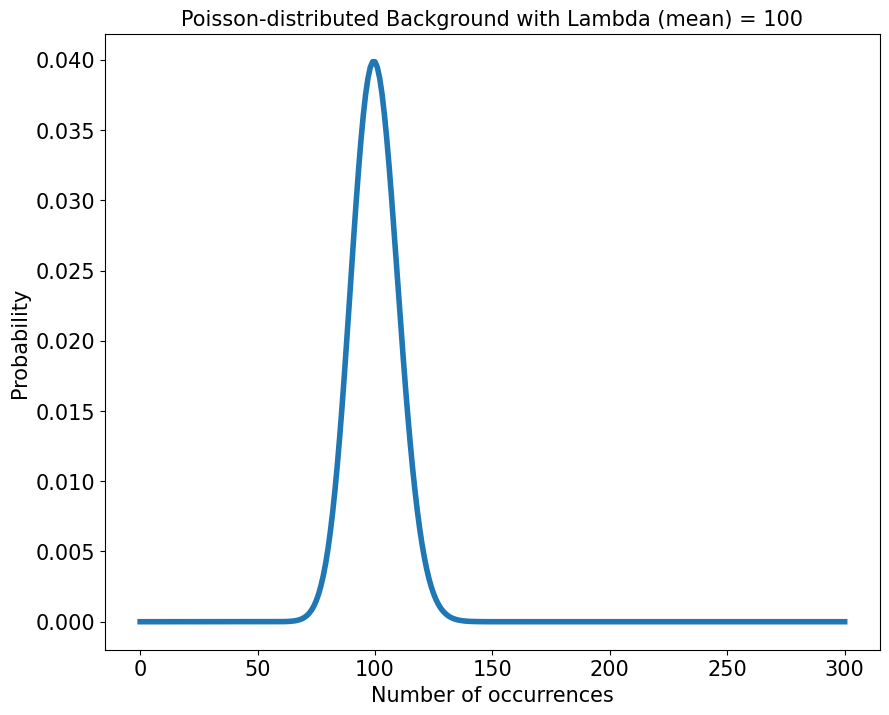

In [2]:
# create background
bkgd_mean = 100
bkgd_x = np.linspace(0,300,301)
bkgd_prob = stats.poisson.pmf(bkgd_x, bkgd_mean)

plt.plot(bkgd_x, bkgd_prob, linewidth = 4)
plt.tick_params(labelsize=15)
plt.xlabel('Number of occurrences', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.title(f'Poisson-distributed Background with Lambda (mean) = 100', fontsize=15)
plt.show()

## Problem 1
First I want to determine where the 5$\sigma$ sensitivity threshold is. I will ask the following statistical question:
__How strong of a signal must I observe for my background to have a probability, corresponding to a significance of 5$\sigma$, of producing that signal?__

I can convert my statistical question to a mathematical expression. First, the Poisson distribution is discreet, with a probability mass function given by $\frac{\lambda^{k} e^{-k}}{k!}$ which gives the probability of obtaining exactly k occurrences.

I will need to convert my threshold of 5$\sigma$ to a corresponding probability of obtaining that threshold using the survival function (sf) of scipy.stats.norm with a normal distribution of mean 0 and standard deviation 1. This integrates the normal distribution between x = 5 to x = $\infty$. Then, I will take this calculated probability and use the inverse survival function on a Poisson distribution with mean 100 to determine what corresponding number of occurences (signal value) I would need to see to get a significance of 5 $\sigma$.

Thus to answer my statistical question, I should solve for x in the following equation, where $\lambda$ = 100:
$$\int_{5}^{\infty} \frac{1}{\sqrt{2\pi}} e^{-x^2/2} dx = \sum_{k=x}^{\infty} \frac{\lambda^{k} e^{-k}}{k!} $$

In [3]:
sigma_a = 5
prob_a = stats.norm.sf(sigma_a)

signal_a = stats.poisson.isf(prob_a, bkgd_mean)
print(f'The signal I must observe for my background have a probability (corresponding to a 5 sigma significance) of producing that signal is {signal_a}.')

The signal I must observe for my background have a probability (corresponding to a 5 sigma significance) of producing that signal is 154.0.


From the plot, I can see that a signal of 154 corresponding to a 5 sigma significance is indeed what I would expect. The signal is greater than the mean and has a very small probability of occurring.

## Problem 2
### Part A
Next let's explore what happens if I inject a signal into my background. 

First I will recreate my background as an array of random variates that are Poisson-distributed with mean 100. Then I will inject a signal of strength 8 $\sigma$ into this and explore it through plotting.

In [4]:
# determine what is a signal of strength 8 sigma is
sigma_b = 8
prob_b = stats.norm.sf(sigma_b)

signal_b = stats.poisson.isf(prob_b, bkgd_mean)
print(f'The signal I must observe for my background to have a probability (corresponding to {sigma_b} sigma significance) of producing that signal is {signal_b}.')

The signal I must observe for my background to have a probability (corresponding to 8 sigma significance) of producing that signal is 190.0.


In [5]:
# define background data and inj_signal as an array
size = 100000
inj_signal = []
for i in range (0, size):
    inj_signal.append(signal_b)
    
N_good = size
bkgd = stats.poisson.rvs(bkgd_mean, size=N_good)
data1 = bkgd + inj_signal

After generating the background and injected signal arrays, I will now create a histogram of how bright an observed signal would appear to be.

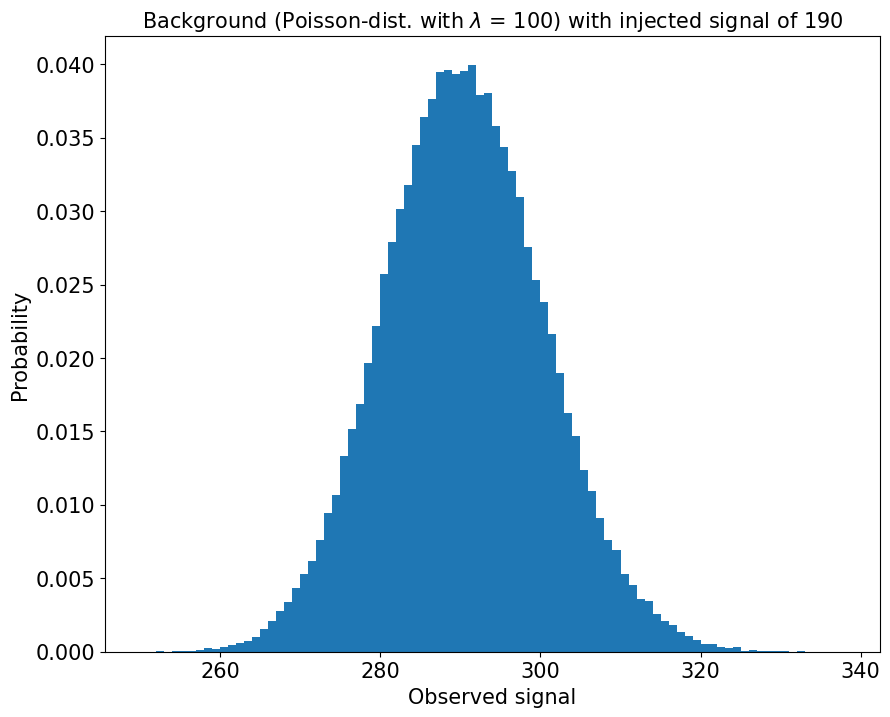

In [6]:
# histogram the data with the injected signal
bins = 88
plt.hist(data1, bins, density = 'True')
plt.tick_params(labelsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.xlabel('Observed signal', fontsize = 15)
plt.title(f'Background (Poisson-dist. with $\lambda$ = 100) with injected signal of 190', fontsize=15)
plt.show()

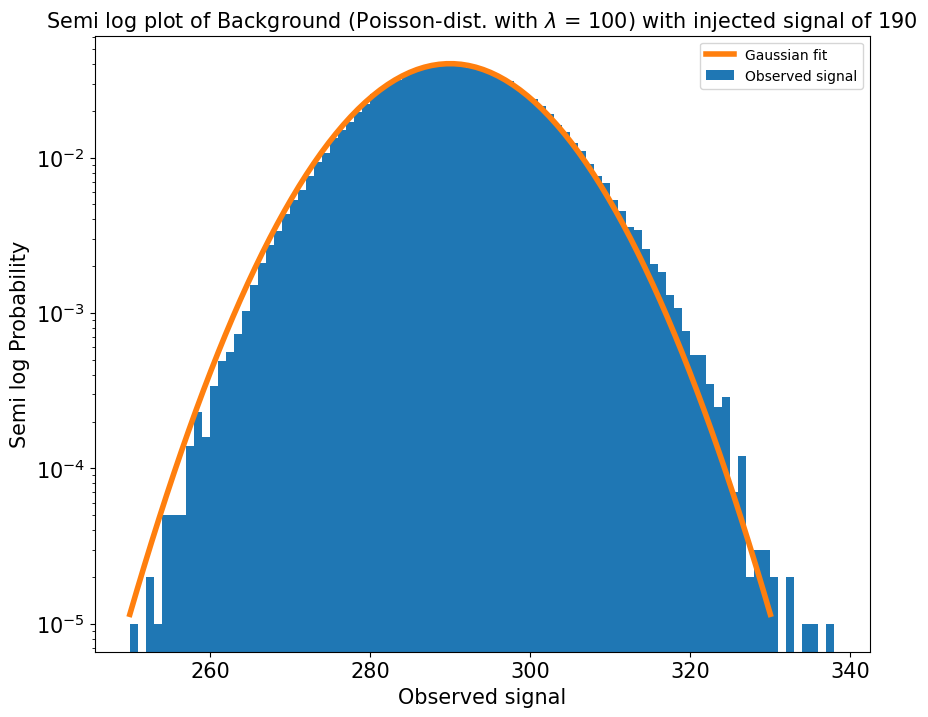

In [7]:
# Plot on a semi-log
x_norm = np.linspace(250, 330, bins)
p_norm = stats.norm.pdf(x_norm, loc = 290, scale = 9.9)

plt.hist(data1, bins, density = 'True', label = 'Observed signal')
plt.plot(x_norm, p_norm, linewidth = 4, label = 'Gaussian fit')
plt.yscale('log')
plt.tick_params(labelsize = 15)
plt.ylabel('Semi log Probability', fontsize = 15)
plt.xlabel('Observed signal', fontsize = 15)
plt.title(f'Semi log plot of Background (Poisson-dist. with $\lambda$ = 100) with injected signal of 190', fontsize=15)
plt.legend()
plt.show()

### Part B
The shape of the histogram resembles a normal distribution with a mean at 290. This is consistent with the Central Limit Theorem, which states that as the sample size gets larger, the distribution of the sample approximates a normal distribution.

I confirmed this shape by plotting my histogram on a semilog plot and I observe that the plot resembles an upside down parabola, which is characteristic of a Gaussian.

This histogram is telling me that the observed signal is most likely to be 290. The probability of obtaining values less than or greater than 290 decreases with observed values farther from 290, and this relationship is approximately symmetric about both sides. Note that the observed signal values tends to be slightly greater than the Gaussian fit would predict for any given probability figure.

My observed signals are all stronger than the true injected signal of 190. In this way my observed signals are biased. The distribution is symmetric about 290, which is the sum of the background's mean (100) and the injected signal value (190).

## Problem 3
### Part A
Now, instead of a constant signal I will look at injecting numerous different signals, this will result in multiple observation distributions for every different signal I inject. I am going to use a range that starts at 0 and I want it to extend well above 5 $\sigma$. Given that I know 5$\sigma$ significance is given by a signal strength of 154, and an 8$\sigma$ is given by a signal strength of 190, I will set my upper range limit to be 400 which is very far away (approx 30$\sigma$ away).

In [43]:
# define background data and inj_signal as an array
num_draws = 10000000 #10 million draws
inj_signal = []
for i in range (0, size):
    inj_signal.append(signal_b)

signals = np.random.uniform(0, 400, num_draws)
bkgd = stats.poisson.rvs(bkgd_mean, size=num_draws)

I am simulating an experiment in which the background is Poisson-distributed with mean of 100, however the signals range from anywhere between 0 and 400. Thus every observed value will have a different probability depending on the injected signal. To plot this I will make a 2D histogram of the injected signals versus the observed data.

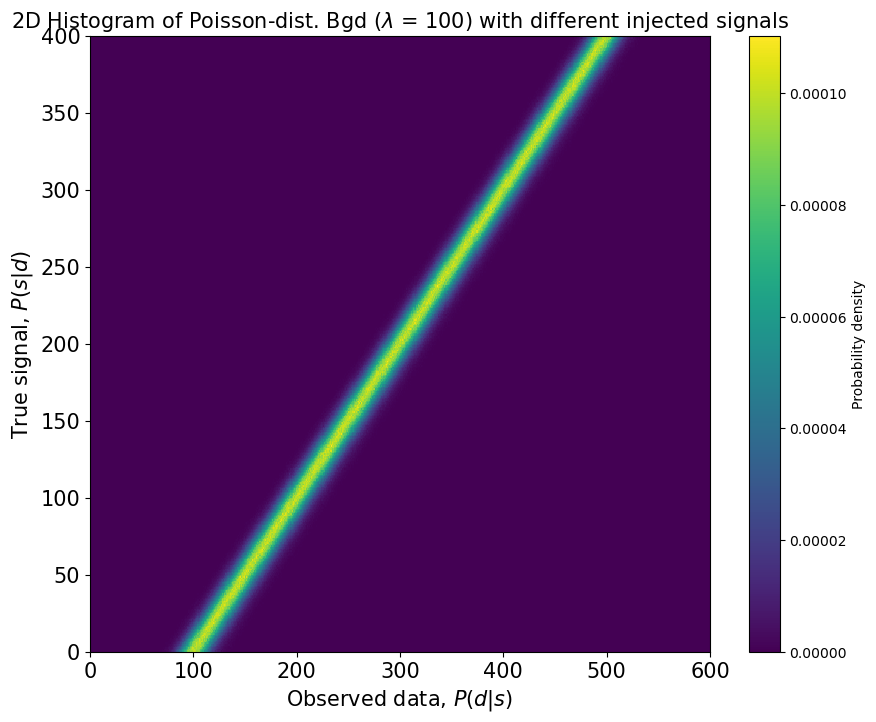

In [44]:
# Add signal to background
data2 = bkgd + signals

# Make histogram
# observed signals (data) - x axis edges
dataedges = np.linspace(0,600,601) # data bins are width 1
# true signals - y axis edges
signaledges = np.linspace(0,400,401) # signal bins are width 1

Psd, temp, temp2 = np.histogram2d(data2, signals, bins=(dataedges, signaledges), density=True)

datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2

plt.pcolormesh(datacenters, signalcenters, Psd.T, shading = 'auto')
plt.colorbar(label = 'Probability density')
plt.title(f'2D Histogram of Poisson-dist. Bgd ($\lambda$ = 100) with different injected signals', fontsize=15)
plt.ylabel('True signal, $P(s|d)$', fontsize = 15)
plt.xlabel('Observed data, $P(d|s)$', fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

### Part B
Next, I would like to take a horizontal slice at the same injected signal I used in Problem 2 (signal of 190). In doing so I would like to take all of the observed data values corresponding to a true signal of 190 and plot it on a 1D histogram to see if I get the same answer.

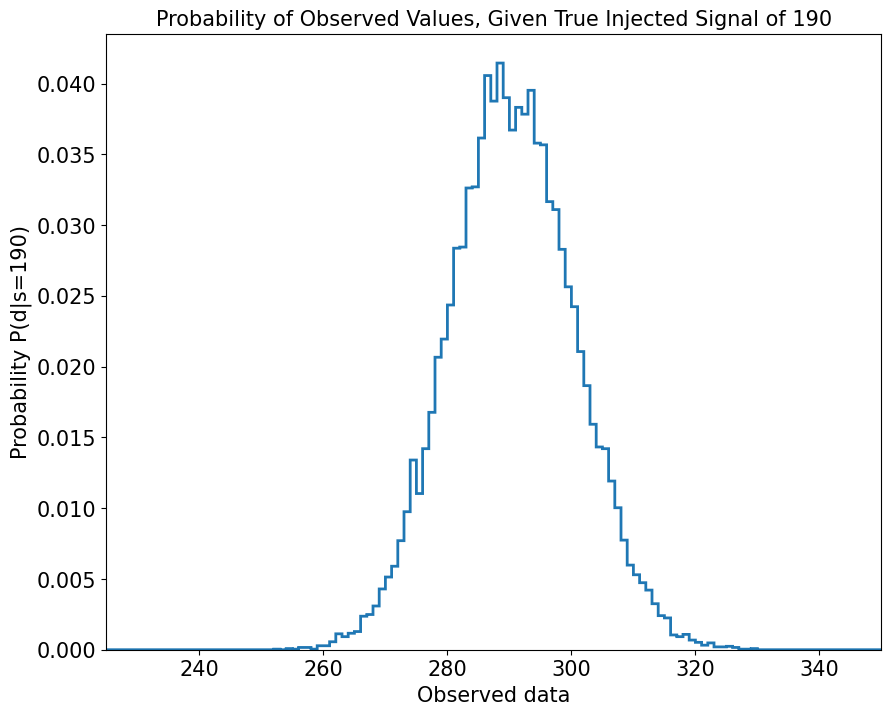

In [46]:
# find the bin index in signaledges
bin_signal = np.digitize(signal_b, signaledges) - 1
    
# Grab only the observed data associated with injected signal bin
# Psd is the 2d histogram with x = observed and y = signals
prob_data = Psd[:, bin_signal]

# Normalize probabilities before plotting
# Bin width is 1
prob_data = prob_data*(1/np.sum(prob_data))

plt.stairs(prob_data, edges = dataedges, linewidth = 2)
plt.title(f'Probability of Observed Values, Given True Injected Signal of 190', fontsize=15)
plt.tick_params(labelsize=15)
plt.ylabel('Probability P(d|s=190)', fontsize = 15)
plt.xlabel('Observed data', fontsize = 15)
plt.xlim(225,350)
plt.show()

As we can see, the plot that I get is the same as my result in Problem 2 Part A. The graphs are both centered at a mean of 290 and are approximately symmetrical on both sides, with probabilities falling off as an approximately normal distribution to both sides. In conclusion I get the same result from taking a horizontal slice at a true signal of 190 from my 2d histogram as I do from only injecting the signal 190 consistently throughout the entire background data. What I conclude is that the 2d histogram allows me to take horizontal slices for any true signal value that I hypothesize working with to see what the observed data's probability distribution looks like.

### Part C
Now I will reverse the problem. Suppose I observe a data value of 250. Let's take a vertical slice at observed data value of 250, and in doing so take the true signal values that correspond to this observed value and create a 1D histogram of the probability distribution.

1.0


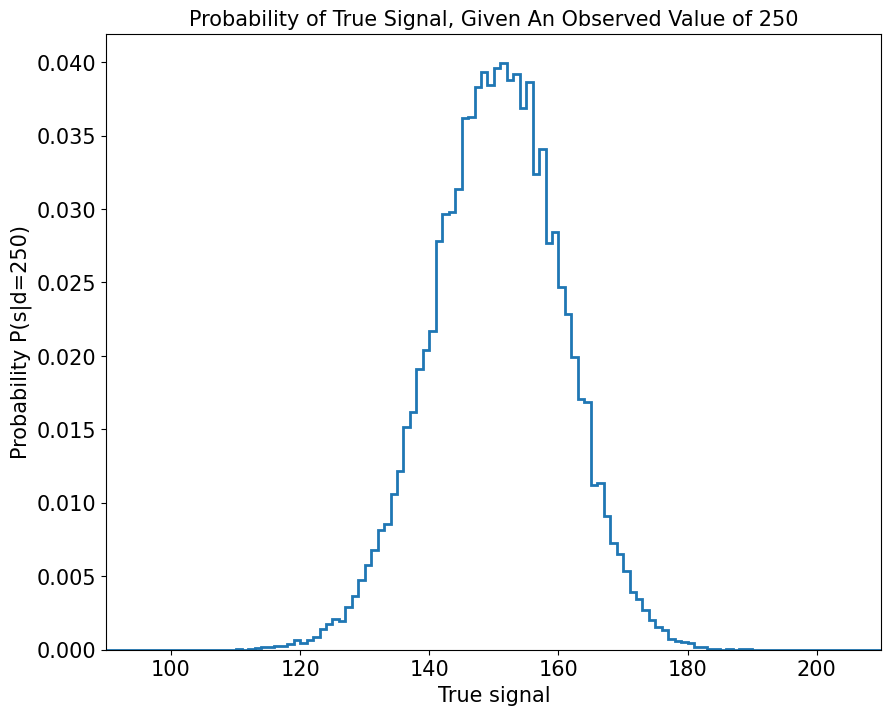

In [48]:
# First let's define our observed signal
obv_signal = 250

# Next, find the bin index in dataedges
bin_obv = np.digitize(obv_signal, dataedges) - 1
    
# Grab only the true signal data associated with observed signal bin
# Psd is the 2d histogram with x = observed and y = signals
prob_signal = Psd[bin_obv, :]

#bin width is 1
prob_signal = prob_signal*(1/(np.sum(prob_signal)))
print(np.sum(prob_data))

plt.stairs(prob_signal, edges = signaledges, linewidth = 2)
plt.title(f'Probability of True Signal, Given An Observed Value of 250', fontsize=15)
plt.tick_params(labelsize=15)
plt.ylabel('Probability P(s|d=250)', fontsize = 15)
plt.xlabel('True signal', fontsize = 15)
plt.xlim(90,210)
plt.show()

I have taken a vertical slice of my 2d histogram at an observed data of 250, this gathers all of the true signals associated with an observation of 250 and I was able to plot this on a stair style plot. This plot is an approximately symmetrical, normal distribution with a mean at around 150. The y axis is probability, and therefore I get a probability distribution of different true signals that could produce an observation of 250.

This distribution makes sense because to receive an observation of 250 I would most likely have a true signal of 150 (since the background has a mean of 100), however I could also observe 250 with a true signal of less or greater than 150 because the background is normally distributed. For instance, a true signal of 140 could also produce an observation of 250 but with smaller probability, and a true signal of 125 could also produce an observation of 250 but with even less probability. Thus, the probability distribution of true signals that could produce an observation of 250 is approximately normally distributed with a mean at 150.

### Part D
Lastly, I would like to explore how I could report what I expect my true signal to be given my hypothetical observation of 250. To report this, I would need to calculate the 1$\sigma$ uncertainty on the true signal strength. 

To calculate the 1$\sigma$ uncertainty I will first calculate what probability this exactly corresponds to, which involves calculating the integral below a normal distribution (mean 0 and standard deviation of 1) away from the mean.

In [49]:
# calculate what is 1 sigma uncertainty away on both sides
prob_one_sigma = stats.norm.cdf(1) - 0.5
print(f'1-sigma away from the mean corresponds to a probability of {prob_one_sigma:.4f}.')

1-sigma away from the mean corresponds to a probability of 0.3413.


Next I will calculate the mean of the true signal probability distribution for a given observation of 250. To do this I will use the following formula to calculate mean:

$$\overline{x} = \sum x P(x)$$

I have the probabilities already stored in a data value prob_signal, and the bin sizes are 1:

In [54]:
# calculate mean = sum (x * prob(x))
mean = 0
for i in range (0, len(prob_signal)):
    mean += prob_signal[i] * signaledges[i]
    
print(f'The mean true signal that would produce an observed value of {obv_signal} is {mean:.4f}.')
print(f'I will use the closest integer value true signal strength of {mean:.1f}')

The mean true signal that would produce an observed value of 250 is 149.9967.
I will use the closest integer value true signal strength of 150.0


In [51]:
bin_mean = np.digitize(mean, signaledges) - 1

total_prob = 0
lower = bin_mean # starts at mean
while total_prob < prob_one_sigma: # until we hit 1 sigma
    lower -= 1 # move to left bin
    total_prob += prob_signal[lower] # add probability to the total prob
    
print(f'The lower bound that encapsulates 1 sigma of true signal values below my mean is {signaledges[lower]}.')

The lower bound that encapsulates 1 sigma of true signal values below my mean is 137.0.


In [52]:
total_prob = 0
upper = bin_mean # starts at mean
while total_prob < prob_one_sigma: # until we hit 1 sigma
    upper += 1 # move to left bin
    total_prob += prob_signal[upper] # add probability to the total prob
    
print(f'The lower bound that encapsulates 1 sigma of true signal values above my mean is {signaledges[upper]}.')

The lower bound that encapsulates 1 sigma of true signal values above my mean is 159.0.


To report the 1 $\sigma$ uncertainty of this true signal probability distribution I would report it as [137, 159].

### Part E
Let me elaborate on my answer in part D. The distribution as we saw is not perfectly symmetric. It is nearly symmetric because the high number of draws makes the probability distribution nearly Gaussian-shaped by the Central Limit Theorem, however it is not perfectly symmetric, otherwise the probabilities on both sides of the mean (150) would be exactly the same and from the graph I can see this is not the case. Therefore I calculated what the 1 sigma uncertainty would be on both sides of the mean separately instead of using the same 1 sigma difference from the mean, which I could do if the distribution was perfectly symmetric.

My probability distribution of true signal values that could produce an observation of 250 is biased because the range of true signals that could possibly produce this observation is entirely below the observation of 250, and is centered around 150. Therefore my distribution has a bias, which does make sense because the background has a non-zero mean.